## Using respredict to predict chemical shifts with python

This notebook shows how to use our Docker image to predict molecules from rdkit

In [1]:
%pylab inline
import numpy as np
from rdkit import Chem
import rdkit.Chem.AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
import pickle
import json
import pandas as pd
from rdkit.Chem import Draw


Populating the interactive namespace from numpy and matplotlib


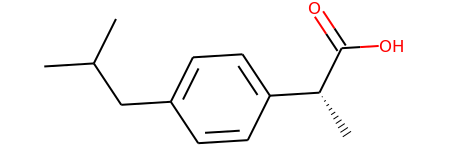

In [2]:
ibuprofen_smiles = "CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O"
mol = Chem.MolFromSmiles(ibuprofen_smiles)
mol

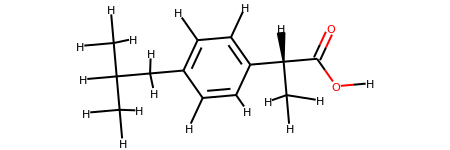

In [3]:
# add Hs 
mol = Chem.AddHs(mol)
# position hydrogens for plotting
Chem.AllChem.Compute2DCoords(mol)
mol

In [4]:
## save the file 
pickle.dump([mol], open("/tmp/test.pickle", 'wb'))

### Running the container
We have a docker container that can be used to run the prediction code. It can accept a variety of formats, here we're using pickled rdkit objects. 

In [5]:
!docker run -i jonaslab/nmr-respredict:beta --help

Usage: predict_standalone.py [OPTIONS]

Options:
  --filename TEXT                 filename of file to read, or stdin if
                                  unspecified
  --format [rdkit|sdf]            file format (sdf, rdkit)
  --nuc [1H|13C]                  Nucleus (1H or 13C)
  --model_meta_filename TEXT
  --model_checkpoint_filename TEXT
  --output TEXT
  --cuda / --no-cuda
  --sanitize / --no-sanitize      sanitize the input molecules
  --addhs TEXT                    Add Hs to the input molecules
  --skip-molecule-errors / --no-skip-molecule-errors
                                  skip any errors
  --help                          Show this message and exit.


The container reads in a binary file from stdin and writes its json output to stdout. Here we show it generating the shifts for carbon atoms

In [6]:
!docker run -i jonaslab/nmr-respredict:beta  --format=rdkit --nuc=13C < /tmp/test.pickle > /tmp/shifts.13C.json        

We can read those shifts in using python's json module:

In [7]:
shift_13C_dict = json.load(open("/tmp/shifts.13C.json"))

In [8]:
shift_13C_dict

{'predictions': [{'smiles': '[H]OC(=O)[C@@]([H])(c1c([H])c([H])c(C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H])C([H])([H])[H]',
   'runtime': 0.08744025230407715,
   'shifts': [{'atom_idx': 0,
     'pred_mu': 22.096878051757812,
     'pred_std': 0.2904541790485382},
    {'atom_idx': 1,
     'pred_mu': 30.1968994140625,
     'pred_std': 0.27719593048095703},
    {'atom_idx': 2,
     'pred_mu': 22.096881866455078,
     'pred_std': 0.29045331478118896},
    {'atom_idx': 3,
     'pred_mu': 45.8773193359375,
     'pred_std': 1.3186558485031128},
    {'atom_idx': 4,
     'pred_mu': 140.06936645507812,
     'pred_std': 0.6302348971366882},
    {'atom_idx': 5,
     'pred_mu': 130.3710479736328,
     'pred_std': 0.5118639469146729},
    {'atom_idx': 6,
     'pred_mu': 128.00685119628906,
     'pred_std': 0.5885018110275269},
    {'atom_idx': 7,
     'pred_mu': 137.044677734375,
     'pred_std': 0.7776199579238892},
    {'atom_idx': 8, 'pred_mu': 128.0068359375, 'pred_std': 0.58850

In [9]:
# We extract the shifts for the first (and only) molecule in our dataset and create a data frame:
first_mol = shift_13C_dict['predictions'][0]
shifts = first_mol['shifts']
pred_df = pd.DataFrame(shifts)
pred_df

,atom_idx,pred_mu,pred_std
0,0,22.096878,0.290454
1,1,30.196899,0.277196
2,2,22.096882,0.290453
3,3,45.877319,1.318656
4,4,140.069366,0.630235
5,5,130.371048,0.511864
6,6,128.006851,0.588502
7,7,137.044678,0.777620
8,8,128.006836,0.588503
9,9,130.371048,0.511864


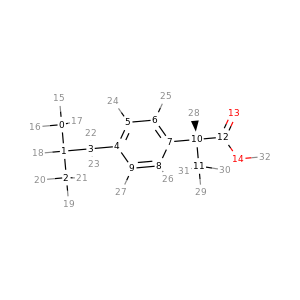

In [10]:
# we can match atom_idx to the atoms in the molecule:
Draw.MolToImage(mol, includeAtomNumbers=True)

Let's look at that dataframe again: it has three columns, atom_idx (zero-indexed), pred_mu (the mean predicted shift) and pred_std, a "confidence estimate". The smaller this number, the more confident we are in the prediction (for more details, see the paper)

In [11]:
pred_df

,atom_idx,pred_mu,pred_std
0,0,22.096878,0.290454
1,1,30.196899,0.277196
2,2,22.096882,0.290453
3,3,45.877319,1.318656
4,4,140.069366,0.630235
5,5,130.371048,0.511864
6,6,128.006851,0.588502
7,7,137.044678,0.777620
8,8,128.006836,0.588503
9,9,130.371048,0.511864
